Collector Analytics - MTG Card Data Analysis
So this notebook is where I dig into the big dataset of MTG cards I pulled from Scryfall.  
Up until this point, I:

- Pulled the data from the Scryfall API
- Cleaned and normalized it
- Loaded it into a SQLite database
- Built a FastAPI backend to serve it
- Built a Streamlit UI to browse and search it

Now it’s time to actually *look* at the data and see what’s interesting — pricing patterns, rarity distribution, which cards spike in value, etc.

Basically: this notebook is the “data analysis” layer of the pipeline.

First i will do some imports

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")


Now i will load the data directly from the SQLITE database into a Pandas Dataframe. This lets me use Python tools for analyzing data more efficiently

In [4]:
DB_FILE = "../data/cards.db"

conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM cards", conn)
conn.close()

df.head()


,id,name,released_at,set_name,collector_number,rarity,type_line,usd_price,usd_foil_price,image_url,scryfall_uri
0,7f5342d5-b8a6-46ee-afd7-b333bb836a7c,Aetherflux Reservoir,2022-11-18,The Brothers' War Retro Artifacts,2,mythic,Artifact,19.70,29.23,https://cards.scryfall.io/normal/front/7/f/7f5...,https://scryfall.com/card/brr/2/aetherflux-res...
1,d93510d4-7772-4260-b862-6dc096496404,Aether Vial,2010-08-27,From the Vault: Relics,1,mythic,Artifact,NaN,6.02,https://cards.scryfall.io/normal/front/d/9/d93...,https://scryfall.com/card/v10/1/aether-vial?ut...
2,884f6948-3e03-48c6-8be2-6f2539386c9d,Aetherworks Marvel,2016-09-30,Kaladesh,193,mythic,Legendary Artifact,0.34,4.58,https://cards.scryfall.io/normal/front/8/8/884...,https://scryfall.com/card/kld/193/aetherworks-...
3,038710ca-c756-4e66-a9de-278e676c9f5b,Aettir and Priwen,2025-06-13,Final Fantasy,253,mythic,Legendary Artifact — Equipment,5.47,7.51,https://cards.scryfall.io/normal/front/0/3/038...,https://scryfall.com/card/fin/253/aettir-and-p...
4,019b51b0-e5c6-4208-922b-7736686dddcd,Agatha's Soul Cauldron,2023-09-08,Wilds of Eldraine,242,mythic,Legendary Artifact,26.68,30.08,https://cards.scryfall.io/normal/front/0/1/019...,https://scryfall.com/card/woe/242/agathas-soul...


Alright now i am going to go over the data to see what it looks like to see if im missing any stats. It does look like im missing values for some of the items. This will need to be remedied by importing more API data at a later date.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                175 non-null    object 
 1   name              175 non-null    object 
 2   released_at       175 non-null    object 
 3   set_name          175 non-null    object 
 4   collector_number  175 non-null    object 
 5   rarity            175 non-null    object 
 6   type_line         175 non-null    object 
 7   usd_price         140 non-null    float64
 8   usd_foil_price    141 non-null    float64
 9   image_url         157 non-null    object 
 10  scryfall_uri      175 non-null    object 
dtypes: float64(2), object(9)
memory usage: 15.2+ KB


In [6]:
df.describe(include="all")

,id,name,released_at,set_name,collector_number,rarity,type_line,usd_price,usd_foil_price,image_url,scryfall_uri
count,175,175,175,175,175,175,175,140.000000,141.000000,157,175
unique,175,175,72,84,119,1,46,NaN,NaN,157,175
top,7f5342d5-b8a6-46ee-afd7-b333bb836a7c,Aetherflux Reservoir,2022-11-18,Transformers,1,mythic,Artifact,NaN,NaN,https://cards.scryfall.io/normal/front/7/f/7f5...,https://scryfall.com/card/brr/2/aetherflux-res...
freq,1,1,26,10,6,175,55,NaN,NaN,1,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.591000,14.929433,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.692054,32.679488,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140000,0.190000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595000,1.210000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.275000,4.620000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.587500,13.100000,NaN,NaN


Since some of the price fields are not available, I'm converting them to numeric format so math and plotting will work without errors.

In [7]:
df['usd_price'] = pd.to_numeric(df['usd_price'], errors='coerce')
df['usd_foil_price'] = pd.to_numeric(df['usd_foil_price'], errors='coerce')

df.isna().sum().sort_values(ascending=False)


usd_price           35
usd_foil_price      34
image_url           18
released_at          0
name                 0
id                   0
set_name             0
type_line            0
rarity               0
collector_number     0
scryfall_uri         0
dtype: int64

This Histogram gives a general idea of how MTG card prices are spread.


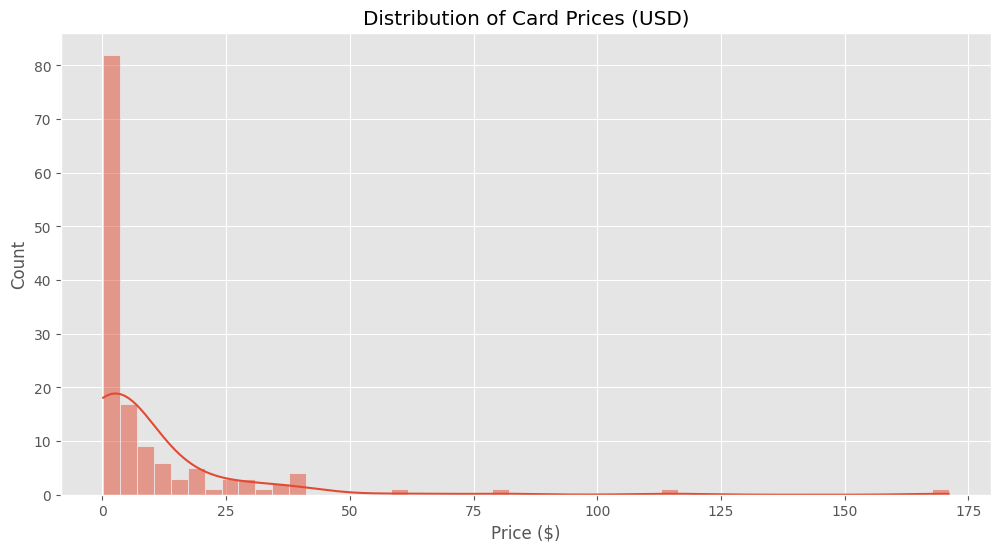

In [8]:
plt.figure(figsize=(12,6))
sns.histplot(df['usd_price'], bins=50, kde=True)
plt.title("Distribution of Card Prices (USD)")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()


I will now pull data on the top 20 most expensive cards in this dataset.

In [9]:
top_20 = df.nlargest(20, 'usd_price')[['name', 'set_name', 'rarity', 'usd_price']]
top_20


,name,set_name,rarity,usd_price
140,Mox Opal,Double Masters,mythic,171.02
37,Chrome Mox,Double Masters,mythic,114.87
123,Mana Vault,Double Masters 2022,mythic,80.70
137,Mox Amber,Dominaria,mythic,60.95
53,Darksteel Forge,Double Masters,mythic,40.53
122,Mana Crypt,Double Masters,mythic,40.26
30,Buster Sword,Final Fantasy,mythic,39.05
46,Commander's Plate,Commander Legends,mythic,38.43
24,Blightsteel Colossus,Double Masters,mythic,37.12
102,Jeweled Lotus,Commander Masters,mythic,34.49


Now I'm checking whether rarity actually correlates with pricing, and how strong that relationship looks.

In [13]:

df_filtered = df[df['usd_price'].notna() & (df['usd_price'] > 0)]

avg_by_rarity = df_filtered.groupby('rarity')['usd_price'].mean().sort_values(ascending=False)
avg_by_rarity


rarity
mythic    9.591
Name: usd_price, dtype: float64

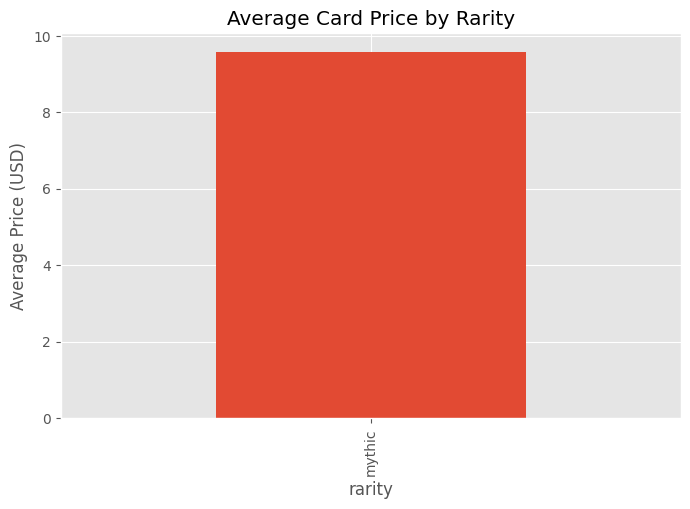

In [14]:
plt.figure(figsize=(8,5))
avg_by_rarity.plot(kind='bar', title="Average Card Price by Rarity")
plt.ylabel("Average Price (USD)")
plt.show()

